In [1]:
# please upload data directory to Google drive before testing
# use Google Drive to load data
from google.colab import drive, files
import zipfile
drive.mount('/content/drive')

zipname = 'supports.zip'
uploaded = files.upload()
# Extract the zip file
with zipfile.ZipFile(zipname, 'r') as zip_ref:
  zip_ref.extractall()  # Extract all files to the current directory

Mounted at /content/drive


Saving supports.zip to supports.zip


In [2]:
!pip install -r "requirements.txt"
!pip install torchinfo
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.9/171.9 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.4/346.4 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.1/117.1 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.0/812.0 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [3]:
from sklearn.model_selection import train_test_split
from models.DCNN import DCNN
import librosa
import numpy as np
from torchinfo import summary
from torch import nn
from torch.optim import Adam
from Utils import read_data,create_dataloader, k_fold_cross_validation, train, test
import matplotlib.pyplot as plt

# Read Data

In [4]:
root = '/content/drive/MyDrive/Data/genres_original' # Change according path storing data
sr = 16 * 1000
x,y,min_length = read_data(root=root, sr=sr)
print("finsh reading data")

finsh reading data


# Segment and Normalise

In [5]:
for i in range(len(x)):
    x[i] = x[i][0:min_length]
    x[i] = librosa.util.normalize(x[i])
x = np.asarray(x)
y = np.asarray(y)
seg_length = 59049 # segment length must be 59049
frame_num = int(x.shape[1]/seg_length)
x = x[:, :frame_num*seg_length].reshape(frame_num*x.shape[0],1,seg_length)
y = (y.reshape(y.shape[0],1)*np.ones((y.shape[0],frame_num))).reshape(y.shape[0]*frame_num)
print("finish segmentation and normalisation")

finish segmentation and normalisation


# Split Data

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,stratify=y,shuffle=True)
# k-fold cross validation
k = 5
xs_train, ys_train, xs_valid, ys_valid = k_fold_cross_validation(x_train,y_train,k)
print("finish splitting data")

finish splitting data


# Create Dataloaders

In [7]:
batch_size = 64 # can be adjusted according to GPU memory size
dataloaders_train = []
dataloaders_valid = []
for i in range(k):
    dataloaders_train.append(create_dataloader(xs_train[i], ys_train[i], batch_size=batch_size,cuda=True))
    dataloaders_valid.append(create_dataloader(xs_valid[i], ys_valid[i], batch_size=batch_size,cuda=True))
dataloader_test = create_dataloader(x_test, y_test, batch_size=batch_size,cuda=True)
print("finish creating dataloaders")

finish creating dataloaders


# Model Construction

In [8]:
model = DCNN(10)
model.cuda()
loss_function = nn.CrossEntropyLoss()
opt = Adam(model.parameters(), lr=0.001)
summary(model,[(batch_size,1,seg_length)])

Layer (type:depth-idx)                   Output Shape              Param #
DCNN                                     [64, 10]                  --
├─ConLayer: 1-1                          [64, 128, 19683]          --
│    └─Conv1d: 2-1                       [64, 128, 19683]          512
│    └─BatchNorm1d: 2-2                  [64, 128, 19683]          256
│    └─ReLU: 2-3                         [64, 128, 19683]          --
├─Sequential: 1-2                        [64, 128, 2187]           --
│    └─ConLayer: 2-4                     [64, 128, 6561]           --
│    │    └─Conv1d: 3-1                  [64, 128, 19683]          49,280
│    │    └─BatchNorm1d: 3-2             [64, 128, 19683]          256
│    │    └─ReLU: 3-3                    [64, 128, 19683]          --
│    │    └─MaxPool1d: 3-4               [64, 128, 6561]           --
│    └─ConLayer: 2-5                     [64, 128, 2187]           --
│    │    └─Conv1d: 3-5                  [64, 128, 6561]           49,280
│   

# Train

In [9]:
epoch = 10
history = train(model,loss_function,opt,dataloaders_train,dataloaders_valid,k,epoch=epoch)
print("finish training")

-------epoch  1 -------
fold 1:
train set loss: 2.069170117378235
train set accuracy: 0.451171875
valid set loss: 2.012753486633301
valid set accuracy: 0.5218750238418579
fold 2:
train set loss: 1.9774481549859046
train set accuracy: 0.6142578125
valid set loss: 1.949862116575241
valid set accuracy: 0.555468738079071
fold 3:
train set loss: 1.9298509284853935
train set accuracy: 0.6898437738418579
valid set loss: 1.914419460296631
valid set accuracy: 0.6695312857627869
fold 4:
train set loss: 1.8915757909417152
train set accuracy: 0.7392578125
valid set loss: 1.921846079826355
valid set accuracy: 0.624218761920929
fold 5:
train set loss: 1.8567814603447914
train set accuracy: 0.7861328125
valid set loss: 1.8731617629528046
valid set accuracy: 0.706250011920929
epoch loss: 1.934
epoch accuracy: 0.615
-------epoch  2 -------
fold 1:
train set loss: 1.8277826607227325
train set accuracy: 0.811718761920929
valid set loss: 1.9098197877407075
valid set accuracy: 0.6078125238418579
fold 2:
tr

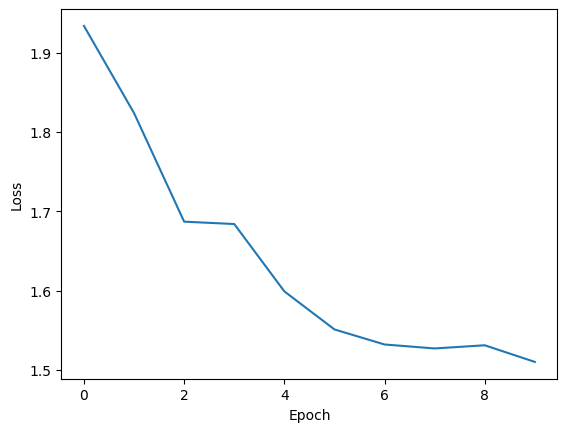

In [10]:
plt.plot(range(epoch),history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

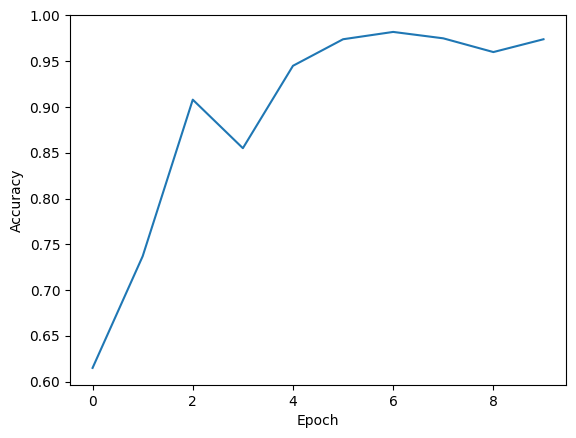

In [11]:
plt.plot(range(epoch), history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Test

In [12]:
loss, acc, AUC, f1 = test(model,loss_function,dataloader_test)

test set loss: 1.665
test set accuracy: 0.796
test set AUC: 0.97
test set f1-score: 0.796
